In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import RandomRotation

torch.multiprocessing.set_start_method('spawn')
torch.set_default_tensor_type('torch.cuda.FloatTensor')

from pyquaternion import Quaternion
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go

from tqdm import tqdm

from src.preprocess import sample_to_rangeview, pcl_to_rangeview
from src.utils import rotation_matrix
from src.settings import DATASET_PATH, LABEL_NUMBER, RV_WIDTH, RV_HEIGHT, NUSCENES
from src.datasets import NuscenesRangeViewDataset
from src.models.lasernet import LaserNet
from src.losses import LaserNetLoss

RuntimeError: context has already been set

---

## Training data 

- ___Classification___ task includes semantic segmentation. We predict class labels for each point (cell) in the Range View. If a cell in RV gets a class C, we extrapolate that all points (which fell into that cell during the transformation to RV) get the same label.
- ___Regression___ task includes BB regression and mixture parameter tuning

so a single training example consists of: 

- __$X$__: range_view image | __5 x W x H__


- __$Y_{image}$:__ | __C x W x H__, where C - number of classes


- __$Y_{bb}$:__ $\{\{b_{m,1}, b_{m,2}, b_{m,3}, b_{m,4}\}, ..., \}_m^M$ | __M x 4 x 2 x W x H__ | where M is the number of bounding boxes in the image, $b_{m, j} \in R ^2$ is the absolute coordinate of $m$-th bounding box's $j$-th corner

- __$Y_{logstd}$:__ $\log(\sigma)$ of the predicted bb coordinates| __scalar__
    

### DataSets, DataLoaders and Transforms

In [28]:
%%time
train_dataset = NuscenesRangeViewDataset(data_root=DATASET_PATH, n=(0, 4))
val_dataset = NuscenesRangeViewDataset(data_root=DATASET_PATH, n=(0, 4))

CPU times: user 0 ns, sys: 6.71 ms, total: 6.71 ms
Wall time: 4.85 ms


/home/narekvslife/lidar-camera-fusion-detection/src/datasets.py:56: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

/home/narekvslife/lidar-camera-fusion-detection/src/datasets.py:57: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [3]:
# %%time
# train_dataset = NuscenesRangeViewDataset(data_root=DATASET_PATH, n=(0, 8064))
# val_dataset = NuscenesRangeViewDataset(data_root=DATASET_PATH, n=(8064, 9152))

In [4]:
train_dataloader = DataLoader(train_dataset, batch_size=4, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=4, num_workers=0)

---

## Training the model

1. For each point in the image, we use the focal loss $L_{prob}$ to learn the class probabilities $\{p_c\}_{c=1}^C$. The classification loss for the entire image is defined as follows 
$$
L_{cls} = {1 \over P} \sum_i{L_{prob, i}}
$$ 
where P is the number of points in the image

2. For each point on an object, we learn the parameters of the object’s mixture model by first identifying which component best matches the ground truth
$$
k^* = \arg \min_k || \hat b_k − b^{gt} ||
$$
where $\hat b_k$ is the k-th mean component of the mixture model
and $b^{gt}$ is the corresponding ground truth bounding box.

3. Afterwards, we update the parameters of the $k^{*}$ component
$$
L_{box} = \sum_n {1 \over \hat \sigma_{k^*}} | \hat b_{n, k} − b^{gt}_n | + \log{\hat \sigma_{k^*}}
$$


4. Next, we update the mixture weights $\{α_k\}^K_{k=1}$ again using the multi-class cross entropy loss $L_{mix}$, where the positive label corresponds to the $k^*$ component

5. The regression loss for the entire image is defined as follows:
$$
L_{reg} = {{1 \over N} \sum_i{L_{box, i} + \lambda L_{mix, i} \over n_i}}
$$
where $L_{box, i}$ and $L_{mix, i}$ are the losses for the $i$-th point in the image which is on an object, $n_i$ is the total number of points that lie on the same object as $i$, $N$ is the total instances of objects in the image, and $\lambda$ is the relative weighting of the two losses.

6. Final loss is 

$$
L = L_{reg} + L_{cls}
$$

___!NOTE! In this experiment we do not model a distribution of BB, which is equivalent to having a single mixture component or  K=1. Meaning: we do not have $L_{mix}$, we skip step 2___

---

In [31]:
# bb_params = torch.Tensor([2, 2, torch.cos(), torch.sin(), 4, 4])
# params_to_box_corners(bb_para):

In [51]:
import torch
import torch.nn as nn

# from src.utils import params_to_box_corners
from src.settings import LABEL_NUMBER
from src.models.dla import DeepLayerAggregation


class LaserNet(nn.Module):

    def __init__(self, num_classes: int = LABEL_NUMBER):
        """
            LaserNet implementation from https://arxiv.org/pdf/1903.08701.pdf almost..

            params:
                num_classes - number of target classes
        """
        super(LaserNet, self).__init__()

        self.num_classes = num_classes

        self.dla = DeepLayerAggregation()

        self.classes = nn.Conv2d(128, self.num_classes, kernel_size=(1, 1))

        # relative center (x, y), relative orientation (wx, wy) = (cos w, sin w), and dimensions l, w
        # + one channel for each class label
        self.bb_params = nn.Conv2d(in_channels=128,
                                   out_channels=6,
                                   kernel_size=(1, 1))
        
        self.log_stds = nn.Conv2d(in_channels=128, 
                                  out_channels=1,
                                  kernel_size=(1, 1))


    def forward(self, x: torch.Tensor) -> tuple:
        """
            x - tensor of size (N, 7, width, height) with main features
                7 for (x, y, height(z), intensity, aziumth, distance
        """
        
        coordinates = x[:, :2]
        x_range_view = x[:, 2:]
        
        dla_out = self.dla(x_range_view)

        class_preds = self.classes(dla_out)
        bb_param_preds = self.bb_params(dla_out)
        log_stds = self.log_stds(dla_out).squeeze()

        # azimuth angle is feature [4] out of 5 channels
        angles = x[:, 4, :, :]

        # bb_preds is of size [N, 6, RV_WIDTH, RV_HEIGHT]
        # for each point on the RV, and each mixture component K we predict 6 params of a bounding box
        # these are relative to the camera frame, we need to turn them to absolute space
        # and we want to get 4 box corners instead of 6 params
        
        bb_corners = params_to_box_corners(bb_param_preds,
                                           coordinates,
                                           angles)

        return class_preds, bb_corners , log_stds

In [53]:
EPOCHS = 2000

lasernet = torch.nn.DataParallel(LaserNet(), device_ids=[0, 1])
loss = LaserNetLoss()
optimizer = torch.optim.Adam(lasernet.parameters(), lr=0.00005)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95)


lasernet.zero_grad()
loss.zero_grad()
optimizer.zero_grad()

train_losses = []
train_accs = []

val_losses = []
val_accs = []
for epoch in range(EPOCHS):
    
    for batch_rv, batch_labels, batch_target_bbs in train_dataloader:
        
        batch_pointclass_preds, batch_bb_param_preds, batch_log_stds = lasernet(x=batch_rv)
                
        L_train = loss(batch_pointclass_preds, batch_bb_param_preds, batch_log_stds, 
                       batch_labels, batch_target_bbs)
        
        lasernet.zero_grad()
        
        if torch.isnan(L_train):
            break
            
        L_train.backward()
        optimizer.step()
    
#     with torch.no_grad():
#         for batch_rv, batch_labels, batch_target_bbs in val_dataloader:
            
#             batch_pointclass_preds, batch_bb_param_preds = lasernet(x=batch_rv)

#             L_val = loss(batch_pointclass_preds, batch_bb_param_preds, batch_labels, batch_target_bbs)
        
#             val_losses.append(L_val.item())

#     torch.save(lasernet, f'lasernet-d{len(train_dataset)}-b64-e{epoch}-adam-lr002-sch095e1')

    if torch.isnan(L_train):
        break
            
    if epoch % 10 == 0:
        batch_pointclass_pred_labels = torch.argmax(batch_pointclass_preds, axis=1)
        batch_pointclass_labels = torch.argmax(batch_labels, axis=1)
        
        correct_preds = torch.sum(batch_pointclass_pred_labels == batch_pointclass_labels)
        all_points = torch.sum(batch_pointclass_labels == batch_pointclass_labels)
        accuracy = (correct_preds / all_points).item() * 100
        
        train_losses.append(L_train.item())
        train_accs.append(accuracy)
        
        print(epoch, "train_loss", L_train.item(), "accuracy",  accuracy) #, "val_loss", L_val.item())
    if epoch % 200 == 0:
        lr_scheduler.step()

|point_classification_loss| 4.270757675170898 |bounding_box_loss| 158.66476440429688
0 train_loss 162.93553161621094 accuracy 0.9796142578125
|point_classification_loss| 4.290427207946777 |bounding_box_loss| 109.76802062988281
|point_classification_loss| 4.263059616088867 |bounding_box_loss| 111.22003173828125
|point_classification_loss| 4.31219482421875 |bounding_box_loss| 117.88426208496094
|point_classification_loss| 4.298478126525879 |bounding_box_loss| 116.96631622314453
|point_classification_loss| 4.272068023681641 |bounding_box_loss| 95.0657958984375
|point_classification_loss| 4.240034103393555 |bounding_box_loss| 94.97499084472656
|point_classification_loss| 4.26149845123291 |bounding_box_loss| 90.53338623046875
|point_classification_loss| 4.240355491638184 |bounding_box_loss| 82.03417205810547
|point_classification_loss| 4.22678279876709 |bounding_box_loss| 76.18428039550781
|point_classification_loss| 4.175296306610107 |bounding_box_loss| 86.37196350097656
10 train_loss 90.5

|point_classification_loss| 3.2515382766723633 |bounding_box_loss| 22.28485107421875
|point_classification_loss| 3.259512424468994 |bounding_box_loss| 26.340774536132812
|point_classification_loss| 3.2130327224731445 |bounding_box_loss| 22.952186584472656
|point_classification_loss| 3.252664804458618 |bounding_box_loss| 22.96816635131836
|point_classification_loss| 3.1627488136291504 |bounding_box_loss| 22.699405670166016
|point_classification_loss| 3.1693286895751953 |bounding_box_loss| 21.9862003326416
|point_classification_loss| 3.1791911125183105 |bounding_box_loss| 23.921180725097656
|point_classification_loss| 3.1254708766937256 |bounding_box_loss| 22.127038955688477
|point_classification_loss| 3.176210641860962 |bounding_box_loss| 23.267139434814453
|point_classification_loss| 3.121664047241211 |bounding_box_loss| 24.919336318969727
100 train_loss 28.041000366210938 accuracy 3.436279296875
|point_classification_loss| 3.124523401260376 |bounding_box_loss| 24.439075469970703
|poin

|point_classification_loss| 2.3774967193603516 |bounding_box_loss| 21.093198776245117
|point_classification_loss| 2.3619327545166016 |bounding_box_loss| 21.06098175048828
|point_classification_loss| 2.373023509979248 |bounding_box_loss| 21.30216407775879
|point_classification_loss| 2.3537259101867676 |bounding_box_loss| 21.103065490722656
|point_classification_loss| 2.397202491760254 |bounding_box_loss| 21.10202980041504
|point_classification_loss| 2.4322166442871094 |bounding_box_loss| 20.416624069213867
|point_classification_loss| 2.3387537002563477 |bounding_box_loss| 20.707366943359375
|point_classification_loss| 2.344721794128418 |bounding_box_loss| 20.631961822509766
|point_classification_loss| 2.3048081398010254 |bounding_box_loss| 20.92315673828125
190 train_loss 23.227962493896484 accuracy 26.4129638671875
|point_classification_loss| 2.286506175994873 |bounding_box_loss| 20.923818588256836
|point_classification_loss| 2.311583995819092 |bounding_box_loss| 21.62224006652832
|poi

KeyboardInterrupt: 

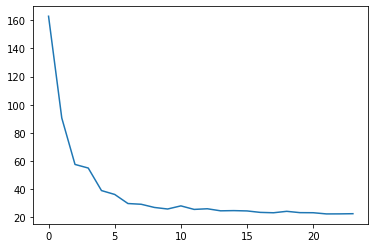

In [54]:
plt.plot(train_losses)
plt.show()

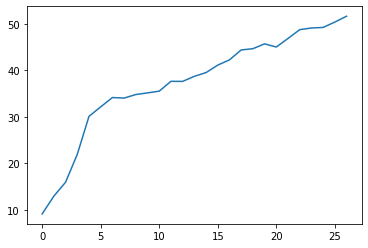

In [44]:
plt.plot(train_accs)
plt.show()

__[3] after transform fix | cross entropy and MSE | no log std | lr=0.001| gamma 097 every 100 epochs__

|point_classification_loss| 0.25498661398887634 |bounding_box_loss| 85.12548828125

1980 train_loss 85.60669708251953 val_loss 85.47611236572266


bad boxes (even lines, not boxes) in the right places!

---
__[4] after transform fix | cross entropy and MSE | no log std | only non-zero boxes | lr=0.001| gamma 097 every 100 epochs____

|point_classification_loss| 0.8824732303619385 |bounding_box_loss| 19.866052627563477

870 train_loss 20.781124114990234 val_loss 20.748525619506836


looks more like boxes, but in the wrong places as well, may fals positives near ego

the further the object is, the thinner is it's bounding box

---

__[5] after transform fix | cross entropy and MSE | no log std | only non-zero boxes | lr=0.01| gamma 097 every 500 epochs__

|point_classification_loss| 0.3059435784816742 |bounding_box_loss| 20.469608306884766

870 train_loss 20.82895851135254 accuracy 89.617919921875

---
__[6] after transform fix| heads no elu | focal loss and log_std error | all boxes | lr=0.00005| gamma 095 every 200 epochs| std for each rv cell| mean by object__

too slow, could ve made the lr bigger or the decrease slower

|point_classification_loss| 0.2606876790523529 |bounding_box_loss| 1.9241503477096558


1990 train_loss 2.184837818145752 accuracy 83.06884765625

---

__[7] after transform fix| heads no elu | focal loss and log_std error | all boxes | lr=0.001| gamma 095 every 500 epochs| std for each rv cell| mean by object__

|point_classification_loss| 0.08178392797708511 |bounding_box_loss| 1.3698492050170898

1990 train_loss 1.4516332149505615 accuracy 93.096923828125

---

__[8] after transform fix| heads no elu | focal loss and mse | selected boxes | lr=0.01| gamma 095 every 500 epochs| std for each rv cell| mean by object | 2k epochs__


|point_classification_loss| 0.15576070547103882 |bounding_box_loss| 1.5972236394882202

1380 train_loss 1.7529842853546143 accuracy 88.897705078125

---

__[9] fixed bb gradient mask| focal loss and mse| selected boxes| lr=0.01| gamma 095 every 500 epochs| std for each rv cell| 2k epochs__

|point_classification_loss| 0.028342999517917633 |bounding_box_loss| 7.2635931968688965

1130 train_loss 7.312100887298584 accuracy 97.137451171875

---

__[10] fixed bb gradient mask| focal loss and mse by sample| selected boxes| lr=0.001| gamma 095 every 500 epochs| std for each rv cell| 2k epochs__

after changing to per-sample loss, training went much better, with general mean, there was no immprovement. bb error started walking around 5

|point_classification_loss| 0.1675342619419098 |bounding_box_loss| 4.894263744354248

1310 train_loss 5.061798095703125 accuracy 88.446044921875


---

__[11] fixed bb gradient mask| focal loss and mse by sample| selected boxes| lr=0.001| gamma 095 every 500 epochs| std for each rv cell| 2k epochs| fixed degrees and radians where neccessary__

much better, but boxes are still smaller than optimal

---

__[12] 11 but with fixed logstd loss. fixed - now it the loss of a sample is the sum of it's bb losses, and the loss of the boxes is the mean loss over samples|  lr=0.00005 | lr decrease 095 every 200__

lr=0.0005 - stuck on 14.5


---

In [ ]:
# torch.save(lasernet, 'lasernet12')

In [46]:
# lasernet = torch.load('lasernet7')

In [47]:
non_object_labels = [0, 24, 25, 26, 27, 28, 29, 30, 31]

with torch.no_grad():
    pointclass_preds, bb_param_preds, _ = lasernet(x=batch_rv)

pointclass_preds = pointclass_preds.detach().cpu().numpy()
bb_corner_preds = bb_param_preds.detach().cpu().numpy()

range_view_ex = batch_rv[1]
class_predictions_ex = pointclass_preds[1]
bb_corner_preds_ex = bb_corner_preds[1]

range_view_ex.shape, class_predictions_ex.shape, bb_corner_preds_ex.shape

(torch.Size([7, 128, 32]), (32, 128, 32), (8, 128, 32))

In [49]:
# Width x Height, max class labels of each cell
class_pred_labels_ex = np.argmax(class_predictions_ex, axis=0)

# sum([class_pred_labels_ex == nol for nol in non_object_labels]) == 0 128x32

indices = np.array(np.nonzero(sum([class_pred_labels_ex == nol for nol in non_object_labels]) == 0)).T
# unique widths and heights of cells wich are classified as objects

# Classes x Width x Height, softmax probabilities of classes in each cell
bb_class_probs_ex = torch.softmax(torch.Tensor(class_predictions_ex), dim=0).cpu().numpy()
print(bb_class_probs_ex.shape)
fig = go.Figure(data=[go.Scatter3d(x=range_view_ex[0].cpu().flatten(),
                                   y=range_view_ex[1].cpu().flatten(),
                                   z=np.zeros_like(range_view_ex[2].cpu().flatten()),
                                   mode='markers',
                                   marker=dict(size=2))])

for w, h in indices:
        # check model's certainty
        class_prob = max(bb_class_probs_ex[:, w, h])
        class_label = np.argmax(bb_class_probs_ex[:, w, h])

        if class_prob > 0.5:
            x = bb_corner_preds_ex[0::2, w, h]
            y = bb_corner_preds_ex[1::2, w, h]
            
            fig.add_mesh3d(x=list(x), 
                           y=list(y),
                           z=np.zeros_like(x))

fig.write_html("kek12.html")

(32, 128, 32)


---

### Adding image information to the LaserNet

In [ ]:
class LaserNetPP(nn.Module):
    pass

### Non-maximum supression

- first we discard all boxes with it's class probability less than 0.6
- then we select the most confident point and get rid of all boxes, that overlap with IoU >= 0.5